In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
import time
from smt.sampling_methods import LHS
#torch.set_default_dtype(torch.float64)
dtype=torch.float64

from E_data_LHS import Move_Time_1D,Pertur_1D,Euler_WENO,IC_Riemann_1D
from E_Plotting import E_plot,  loss_plot 

# Full PINN
from E_PINN_WE import PINNs_WE_Euler_1D
#from E_PINN_train_plot import pinn_train

# TGPT-PINN
#from E_TGPT_PINN import GPT
#from E_TGPT_train import gpt_train
from E_TGPT_activation import P

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
#torch.manual_seed(12)
#np.random.seed(12)
#setup_seed(7)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 5000 == 0):
        ind = 100
        plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
        plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
        plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"

        x = np.linspace(0.0, 1.0, 100)                                   
        t = np.linspace(Te, Te, 1)                                     
        t_grid, x_grid = np.meshgrid(t, x)                               
        T = t_grid.flatten()[:, None]                                    
        X = x_grid.flatten()[:, None]                                    
        x_test = np.hstack((T, X))                                       
        x_test = torch.tensor(x_test, dtype=dtype).to(device)
        #u_pred = to_numpy(model(x_test))
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={round((ind-1)*(Te-Ts)/(Nt_test-1),3)}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

def train2(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde2(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 500 == 0):
        ind = 100
        plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
        plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
        plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"

        x = np.linspace(0.0, 1.0, 100)                                   
        t = np.linspace(Te, Te, 1)                                     
        t_grid, x_grid = np.meshgrid(t, x)                               
        T = t_grid.flatten()[:, None]                                    
        X = x_grid.flatten()[:, None]                                    
        x_test = np.hstack((T, X))                                       
        x_test = torch.tensor(x_test, dtype=dtype).to(device)
        #u_pred = to_numpy(model(x_test))
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={round((ind-1)*(Te-Ts)/(Nt_test-1),3)}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

In [3]:
# Initial and Boundary Conditions
crhoL = 0.445
cuL = 0.698
cpL = 3.528
crhoR = 0.3
cuR = 0.0
cpR = 0.571

ini = [crhoL,cpL,cuL,crhoR,cpR,cuR]

# Domain and Data
#Xi, Xf         =  -1.0, 2.0
Xs, Xe         =  0.0, 1.0
Ts, Te         =  0.0, 0.1
Nc, Nx_test     =  100, 100
Tc, Nt_test     =  100, 100
N_simple       =  10000
IC_pts         =  1000
N_RH           =  1000
dx = 0.01
dt = 0.002

gamma = 1.4
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object)

xlimits = np.array([[0.,Te],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_int= sampling(30000)

xlimits = np.array([[0.,0],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic= sampling(1000)

xlimits = np.array([[0.,Te],[0, 0]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcL= sampling(100)
xlimits = np.array([[0.,Te],[Xe, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcR= sampling(1000)
x_bc = np.vstack((x_bcL,x_bcR))

rho_ic, u_ic, p_ic= IC_Riemann_1D(x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR)                    
rho_bc, u_bc, p_bc= IC_Riemann_1D(x_bc,crhoL,cuL,cpL,crhoR,cuR,cpR)     

xrh,xrhL,xrhR,xrhP,xrhPL,xrhPR = Pertur_1D(x_ic,Te,dt,dx)

x_en = Move_Time_1D(x_ic,Te)

x_ic = torch.tensor(x_ic,dtype=dtype).to(device)
x_bc = torch.tensor(x_bc,dtype=dtype).to(device)
x_int = torch.tensor(x_int,requires_grad=True, dtype=dtype).to(device)
x_en = torch.tensor(x_en,  dtype=dtype).to(device)
xrh = torch.tensor(xrh,  dtype=dtype).to(device)
xrhL = torch.tensor(xrhL,  dtype=dtype).to(device)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(device)
u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
p_ic = torch.tensor(p_ic, dtype=dtype).to(device)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(device)
u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
p_bc = torch.tensor(p_bc, dtype=dtype).to(device)

#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

from E_solver import exact_solver
weno_u = exact_solver([crhoL,cuL,cpL],[crhoR,cuR,cpR],gamma,Te,N=200)

In [4]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,20000,25000]
layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 30, 30,30,30, 3])
tol         = 1e-2

Start training...
epoch 1 loss_pde:0.00265279, loss_ic:6.33320599, loss_rh:0.00000000,loss_con:0.84715253
loss_tot:162.77941344
epoch 2 loss_pde:0.00685310, loss_ic:6.02695618, loss_rh:0.00000000,loss_con:0.84036004
loss_tot:157.78497588
epoch 3 loss_pde:0.01429876, loss_ic:5.71186857, loss_rh:0.00000000,loss_con:0.83226508
loss_tot:152.62146247
epoch 4 loss_pde:0.02658904, loss_ic:5.37743223, loss_rh:0.00000000,loss_con:0.82257777
loss_tot:147.13832176
epoch 5 loss_pde:0.04568055, loss_ic:5.02012851, loss_rh:0.00000000,loss_con:0.81112066
loss_tot:141.30965465
epoch 6 loss_pde:0.07402277, loss_ic:4.64194407, loss_rh:0.00000000,loss_con:0.79770882
loss_tot:135.20069084
epoch 7 loss_pde:0.11478459, loss_ic:4.25012937, loss_rh:0.00000000,loss_con:0.78211205
loss_tot:128.95942281
epoch 8 loss_pde:0.17208607, loss_ic:3.85715648, loss_rh:0.00000000,loss_con:0.76402400
loss_tot:122.80606360
epoch 9 loss_pde:0.25113018, loss_ic:3.48022959, loss_rh:0.00000000,loss_con:0.74303015
loss_tot:117.0

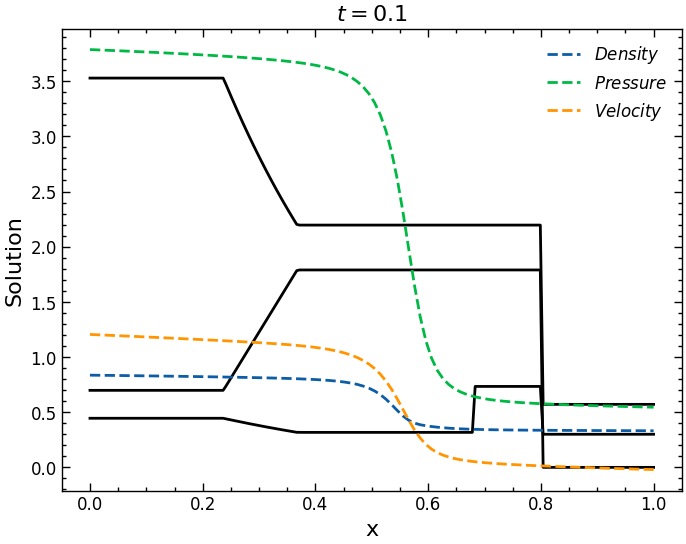

loss_tot:4.87713644
epoch 5001 loss_pde:0.80163336, loss_ic:0.18882307, loss_rh:0.00000000,loss_con:0.01807413
loss_tot:4.87360445
epoch 5002 loss_pde:0.80205543, loss_ic:0.18869743, loss_rh:0.00000000,loss_con:0.01804965
loss_tot:4.87007371
epoch 5003 loss_pde:0.80247866, loss_ic:0.18857196, loss_rh:0.00000000,loss_con:0.01802515
loss_tot:4.86654387
epoch 5004 loss_pde:0.80290328, loss_ic:0.18844666, loss_rh:0.00000000,loss_con:0.01800064
loss_tot:4.86301524
epoch 5005 loss_pde:0.80332887, loss_ic:0.18832153, loss_rh:0.00000000,loss_con:0.01797612
loss_tot:4.85948747
epoch 5006 loss_pde:0.80375561, loss_ic:0.18819655, loss_rh:0.00000000,loss_con:0.01795159
loss_tot:4.85596079
epoch 5007 loss_pde:0.80418291, loss_ic:0.18807173, loss_rh:0.00000000,loss_con:0.01792705
loss_tot:4.85243467
epoch 5008 loss_pde:0.80461097, loss_ic:0.18794708, loss_rh:0.00000000,loss_con:0.01790250
loss_tot:4.84890939
epoch 5009 loss_pde:0.80503948, loss_ic:0.18782257, loss_rh:0.00000000,loss_con:0.01787795
l

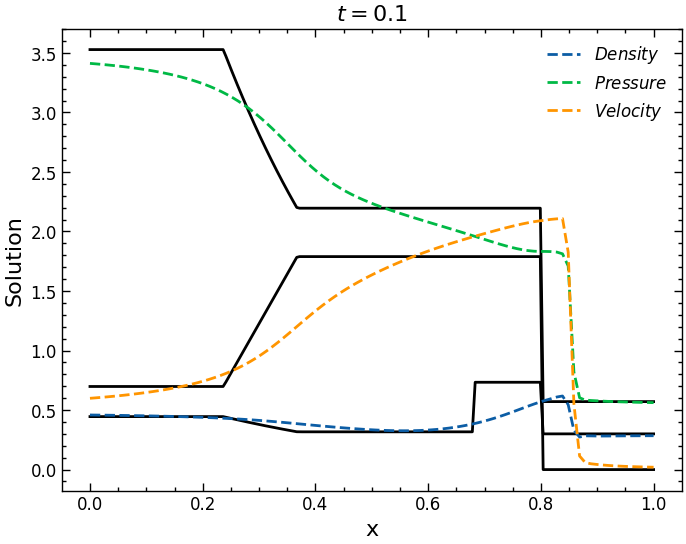

loss_tot:0.50905722
epoch 10001 loss_pde:0.19285166, loss_ic:0.03072468, loss_rh:0.00010710,loss_con:0.00020042
loss_tot:0.54973212
epoch 10002 loss_pde:0.19756834, loss_ic:0.02481525, loss_rh:0.00010970,loss_con:0.00007740
loss_tot:0.48456343
epoch 10003 loss_pde:0.21381508, loss_ic:0.02404926, loss_rh:0.00009662,loss_con:0.00012115
loss_tot:0.49709836
epoch 10004 loss_pde:0.20009145, loss_ic:0.04959331, loss_rh:0.00009755,loss_con:0.00060887
loss_tot:0.78741827
epoch 10005 loss_pde:0.20150252, loss_ic:0.02585741, loss_rh:0.00010496,loss_con:0.00017421
loss_tot:0.51202390
epoch 10006 loss_pde:0.15788248, loss_ic:0.03101597, loss_rh:0.00010856,loss_con:0.00109603
loss_tot:0.60931547
epoch 10007 loss_pde:0.16616307, loss_ic:0.02347067, loss_rh:0.00011600,loss_con:0.00062246
loss_tot:0.49088827
epoch 10008 loss_pde:0.41461198, loss_ic:0.02212444, loss_rh:0.00010820,loss_con:0.00013625
loss_tot:0.67979556
epoch 10009 loss_pde:0.15386099, loss_ic:0.02301938, loss_rh:0.00011123,loss_con:0.0

In [5]:
model =  PINNs_WE_Euler_1D(Nl=6,Nn=60).to(device).double()
print('Start training...')
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.2:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')

In [6]:
print(model.net.Linear_layer_1.weight.grad.data.dtype)

torch.float64


epoch 0 loss_pde:1.41676196, loss_ic:0.01392088, loss_rh:0.00009197,loss_con:0.00006122
epoch 0 loss_pde:1.06397126, loss_ic:0.01943563, loss_rh:0.00009209,loss_con:0.00005157
epoch 0 loss_pde:1.06391897, loss_ic:0.01920229, loss_rh:0.00009219,loss_con:0.00004832
epoch 0 loss_pde:1.06214313, loss_ic:0.01866424, loss_rh:0.00009239,loss_con:0.00004294
epoch 0 loss_pde:1.05836817, loss_ic:0.01777916, loss_rh:0.00009251,loss_con:0.00003760
epoch 0 loss_pde:1.05317456, loss_ic:0.01710643, loss_rh:0.00009256,loss_con:0.00003336
epoch 0 loss_pde:1.04646749, loss_ic:0.01663366, loss_rh:0.00009257,loss_con:0.00003002
epoch 0 loss_pde:1.03790195, loss_ic:0.01627323, loss_rh:0.00009260,loss_con:0.00002709
epoch 0 loss_pde:1.02733872, loss_ic:0.01597412, loss_rh:0.00009255,loss_con:0.00002467
epoch 0 loss_pde:1.01450876, loss_ic:0.01569748, loss_rh:0.00009238,loss_con:0.00002245
epoch 0 loss_pde:0.99916983, loss_ic:0.01545294, loss_rh:0.00009208,loss_con:0.00002010
epoch 0 loss_pde:0.98189842, los

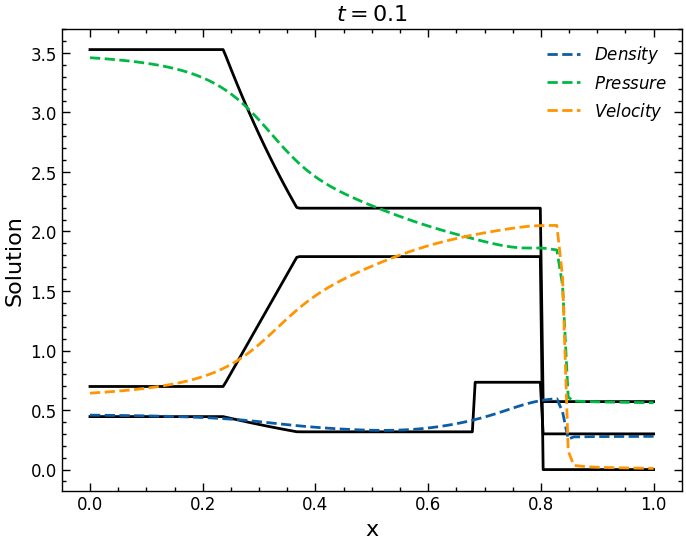

loss_tot:1.58105308
epoch 1 loss_pde:0.79874324, loss_ic:0.01772366, loss_rh:0.00008598,loss_con:0.00002040
epoch 1 loss_pde:0.78123818, loss_ic:0.01820766, loss_rh:0.00008443,loss_con:0.00002175
epoch 1 loss_pde:0.76168482, loss_ic:0.01879798, loss_rh:0.00008250,loss_con:0.00002346
epoch 1 loss_pde:0.74565760, loss_ic:0.01933101, loss_rh:0.00008101,loss_con:0.00002454
epoch 1 loss_pde:0.72977923, loss_ic:0.01984772, loss_rh:0.00007859,loss_con:0.00002269
epoch 1 loss_pde:0.71272537, loss_ic:0.02044981, loss_rh:0.00007689,loss_con:0.00002441
epoch 1 loss_pde:0.69603074, loss_ic:0.02103504, loss_rh:0.00007436,loss_con:0.00001636
epoch 1 loss_pde:0.67977576, loss_ic:0.02164568, loss_rh:0.00007270,loss_con:0.00001669
epoch 1 loss_pde:0.66190288, loss_ic:0.02227034, loss_rh:0.00007111,loss_con:0.00001762
epoch 1 loss_pde:0.64165770, loss_ic:0.02297882, loss_rh:0.00006937,loss_con:0.00001763
epoch 1 loss_pde:0.62197116, loss_ic:0.02363271, loss_rh:0.00006790,loss_con:0.00001641
epoch 1 loss

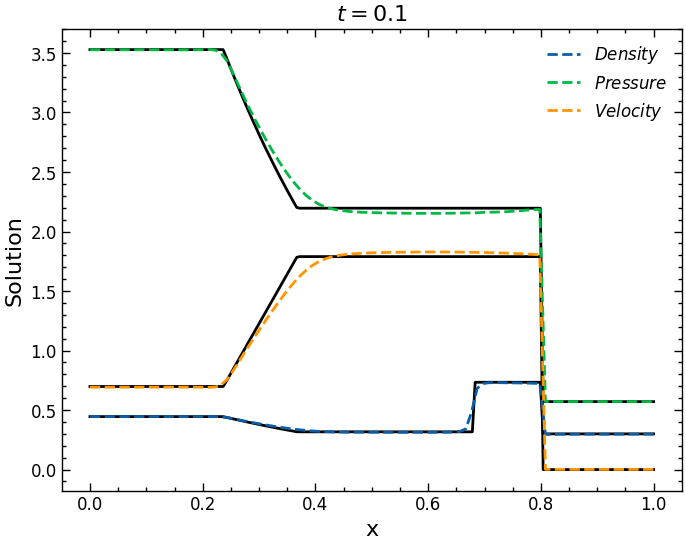

loss_tot:0.01447264
epoch 501 loss_pde:0.01290117, loss_ic:0.00008162, loss_rh:0.00000617,loss_con:0.00000007
epoch 501 loss_pde:0.01290074, loss_ic:0.00008154, loss_rh:0.00000616,loss_con:0.00000007
epoch 501 loss_pde:0.01289978, loss_ic:0.00008143, loss_rh:0.00000616,loss_con:0.00000007
epoch 501 loss_pde:0.01289970, loss_ic:0.00008133, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289927, loss_ic:0.00008127, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289862, loss_ic:0.00008115, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289820, loss_ic:0.00008105, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289775, loss_ic:0.00008098, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289717, loss_ic:0.00008087, loss_rh:0.00000615,loss_con:0.00000007
epoch 501 loss_pde:0.01289666, loss_ic:0.00008076, loss_rh:0.00000614,loss_con:0.00000007
epoch 501 loss_pde:0.01289560, loss_ic:0.00008064, loss_rh:0.00000614,loss_con:0

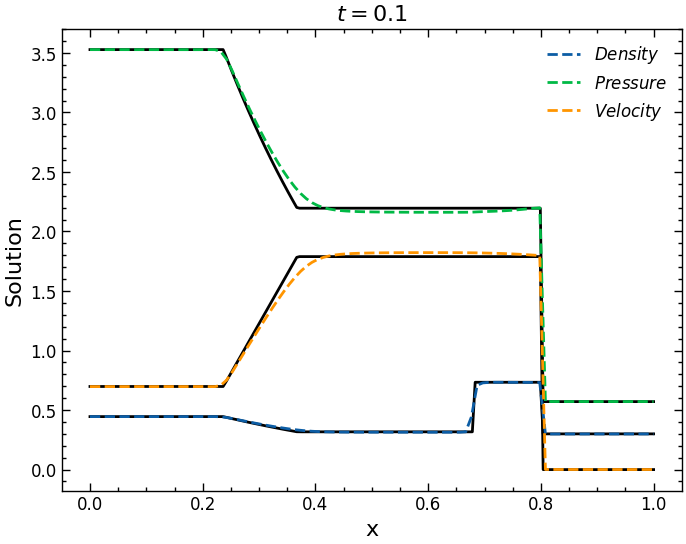

loss_tot:0.00612199
epoch 1001 loss_pde:0.00585379, loss_ic:0.00001928, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585322, loss_ic:0.00001929, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585288, loss_ic:0.00001929, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585255, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585222, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585191, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585165, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585136, loss_ic:0.00001929, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585107, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585074, loss_ic:0.00001930, loss_rh:0.00000061,loss_con:0.00000001
epoch 1001 loss_pde:0.00585039, loss_ic:0.00001930, loss_rh:0.00000061

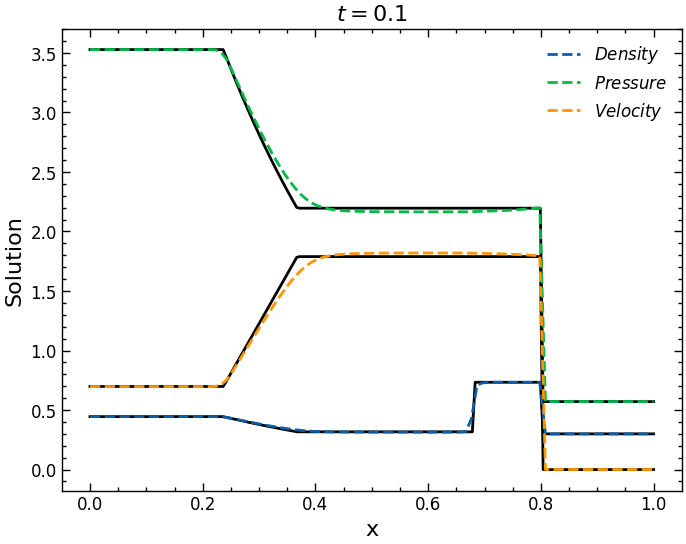

loss_tot:0.00477102
epoch 1501 loss_pde:0.00462952, loss_ic:0.00001039, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462943, loss_ic:0.00001039, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462943, loss_ic:0.00001038, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462942, loss_ic:0.00001038, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462939, loss_ic:0.00001038, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462938, loss_ic:0.00001038, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462937, loss_ic:0.00001037, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462936, loss_ic:0.00001037, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462935, loss_ic:0.00001037, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462935, loss_ic:0.00001037, loss_rh:0.00000034,loss_con:0.00000001
epoch 1501 loss_pde:0.00462935, loss_ic:0.00001036, loss_rh:0.00000034

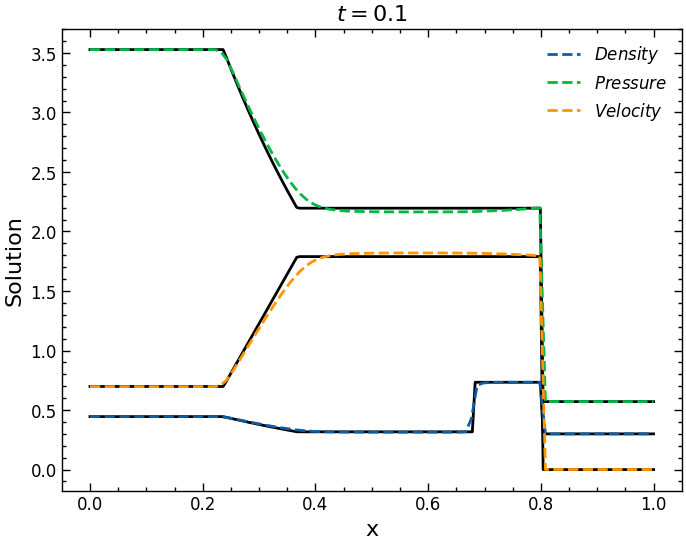

loss_tot:0.00444448
epoch 2001 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
epoch 2001 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2002 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
epoch 2002 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2003 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
epoch 2003 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2004 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
epoch 2004 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2005 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
epoch 2005 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0

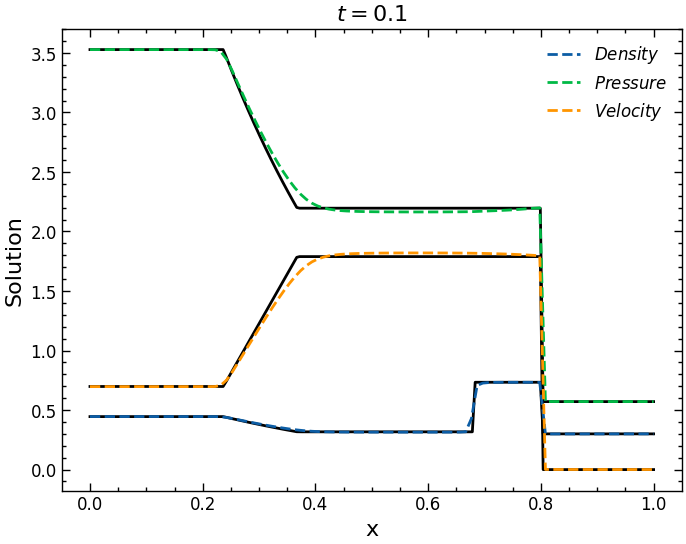

loss_tot:0.00444448
epoch 2501 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2502 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2503 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2504 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2505 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2506 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2507 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2508 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 2509 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
l

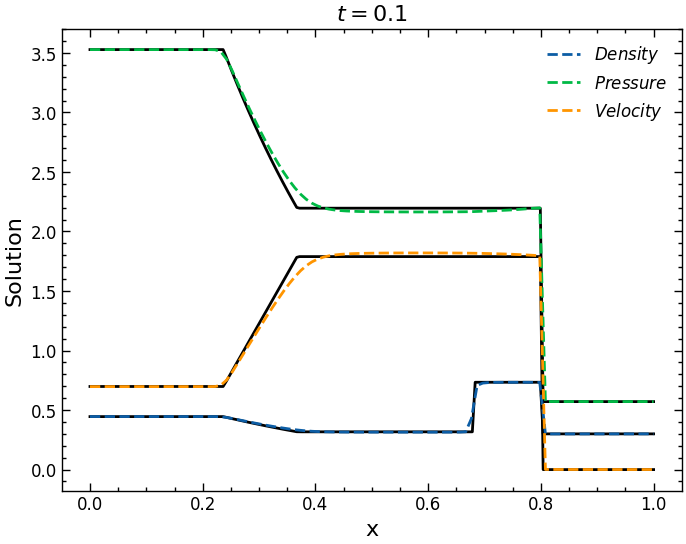

loss_tot:0.00444448
epoch 3001 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3002 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3003 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3004 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3005 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3006 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3007 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3008 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3009 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
l

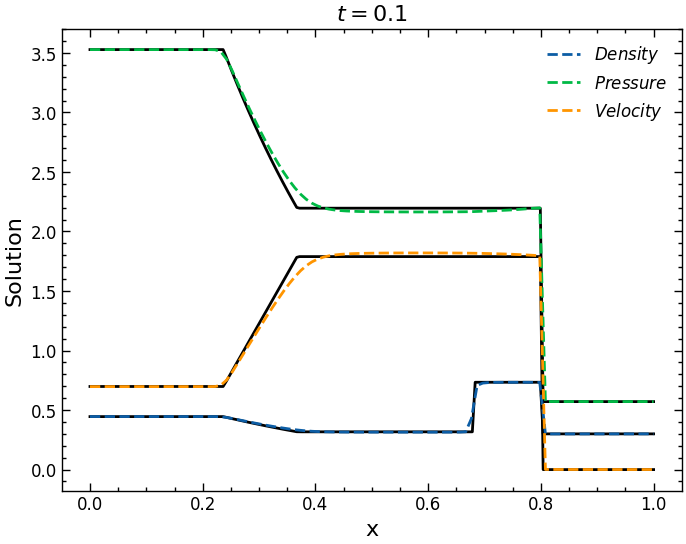

loss_tot:0.00444448
epoch 3501 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3502 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3503 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3504 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3505 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3506 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3507 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3508 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 3509 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
l

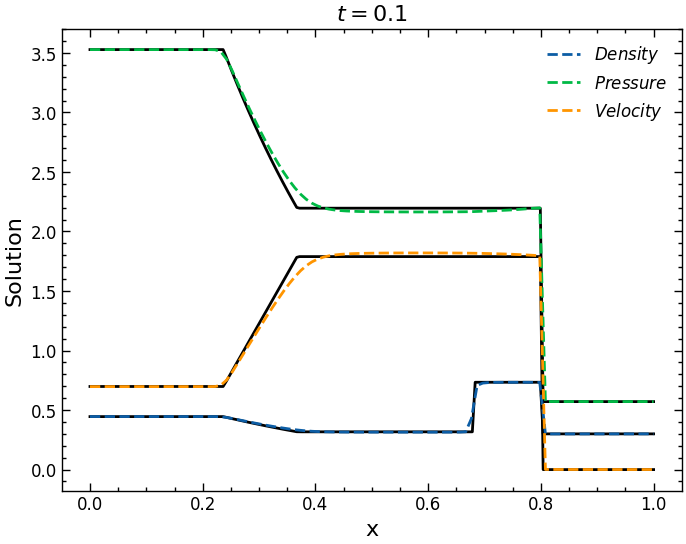

loss_tot:0.00444448
epoch 4001 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4002 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4003 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4004 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4005 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4006 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4007 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4008 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4009 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
l

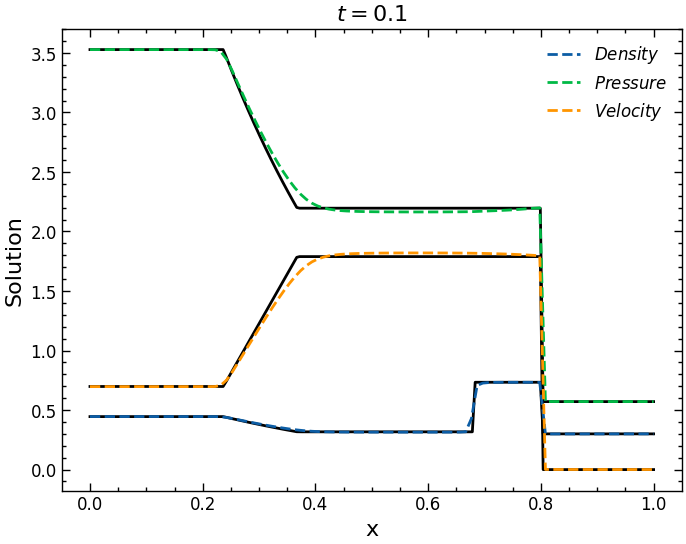

loss_tot:0.00444448
epoch 4501 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4502 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4503 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4504 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4505 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4506 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4507 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4508 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
loss_tot:0.00444448
epoch 4509 loss_pde:0.00430984, loss_ic:0.00000989, loss_rh:0.00000030,loss_con:0.00000004
l

In [7]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

epochi = 0

epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train2(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
  #  if loss < 0.005:
   #     break
toc = time.time()

print(f'Total training time: {toc - tic}')

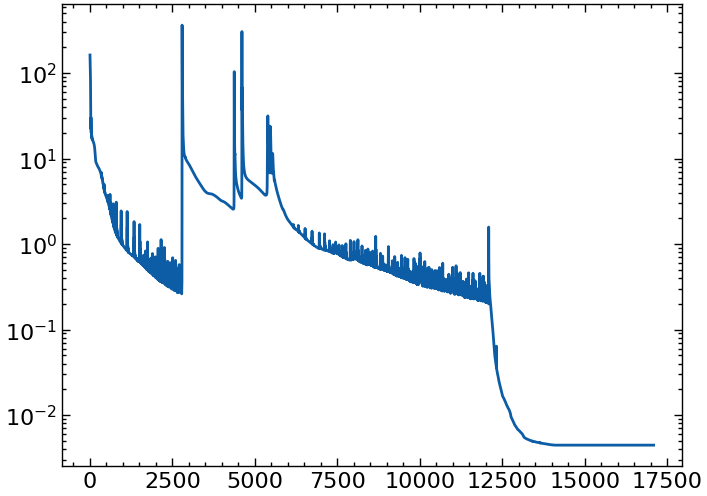

In [8]:
plt.plot(loss_history)
plt.yscale('log')

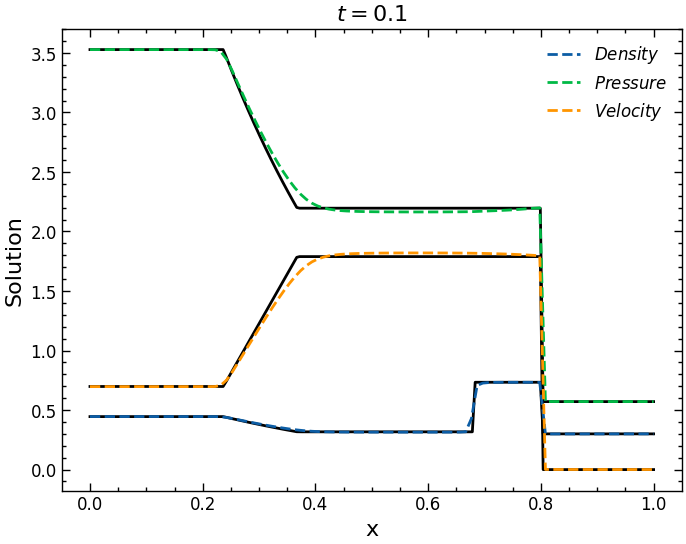

In [9]:
#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

ind = 100
plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"

x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)
#u_pred = to_numpy(model(x_test))
plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
plt.xlabel("x",     fontsize=16)
plt.ylabel("Solution", fontsize=16)
plt.title(fr"$t={round((ind-1)*(Te-Ts)/(Nt_test-1),3)}$")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

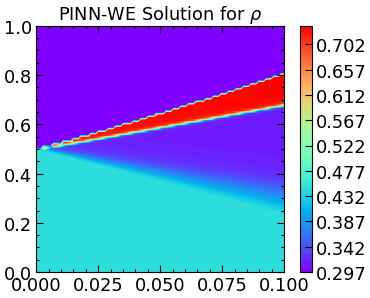

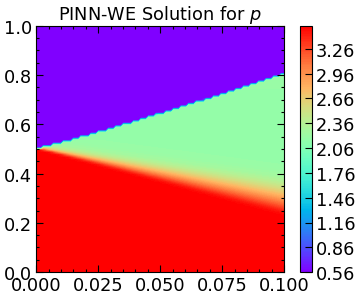

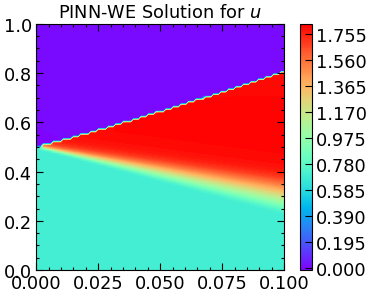

In [10]:
from E_data import create_residual_data
xt_test = create_residual_data(Xs, Xe, Ts, Te, Nc, Nx_test,Tc,Nt_test,N_simple)[2].to(device) 

E_plot(xt_test, model(xt_test)[:,:1], dpi=80, figsize=(5,4),title=fr"PINN-WE Solution for $\rho$")
E_plot(xt_test, model(xt_test)[:,1:2], dpi=80, figsize=(5,4),title=fr"PINN-WE Solution for $p$")
E_plot(xt_test, model(xt_test)[:,2:], dpi=80, figsize=(5,4),title=fr"PINN-WE Solution for $u$")

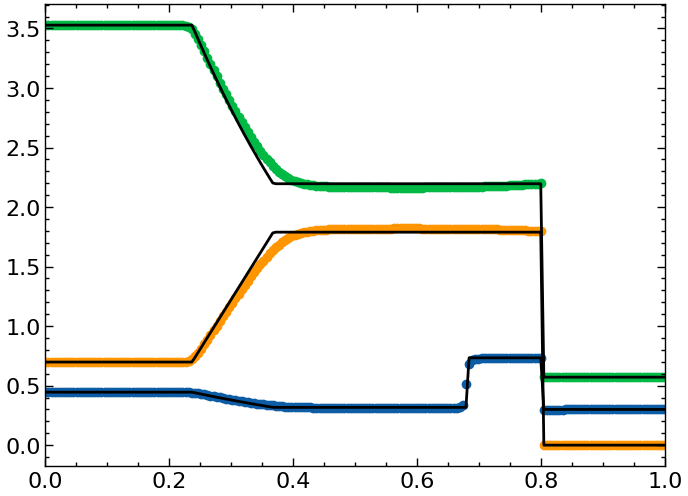

In [11]:
x = np.linspace(0.0, 1.0, 200)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [12]:
np.sqrt(((weno_u[0]-u_pred[:,0])**2).mean())

0.18996070800585874

In [13]:
np.sqrt(((weno_u[1]-u_pred[:,1])**2).mean())

1.4262435736173362

In [14]:
np.sqrt(((weno_u[2]-u_pred[:,2])**2).mean())

1.003551140116393

In [15]:
from E_TGPT_activation import P
layers_pinn = np.array([2,60,60,60,60,60,3])

w1 = model.net.Linear_layer_1.weight.detach().cpu()
w2 = model.net.Linear_layer_2.weight.detach().cpu()
w3 = model.net.Linear_layer_3.weight.detach().cpu()
w4 = model.net.Linear_layer_4.weight.detach().cpu()
w5 = model.net.Linear_layer_5.weight.detach().cpu()
w6 = model.net.Linear_layer_final.weight.detach().cpu()
#w7 = PINN.linears[6].weight.detach().cpu()

b1 = model.net.Linear_layer_1.bias.detach().cpu()
b2 = model.net.Linear_layer_2.bias.detach().cpu()
b3 = model.net.Linear_layer_3.bias.detach().cpu()
b4 = model.net.Linear_layer_4.bias.detach().cpu()
b5 = model.net.Linear_layer_5.bias.detach().cpu()
b6 = model.net.Linear_layer_final.bias.detach().cpu()
#b7 = PINN.linears[6].bias.detach().cpu()

# Add new activation functions
P_list = P(layers_pinn, w1, w2, w3, w4, w5,w6, b1, b2, b3, b4,b5,b6).to(device)

import pickle 
with open('PINNWE0410_Lax030_t01.pkl', 'wb') as f:
    pickle.dump(P_list, f)

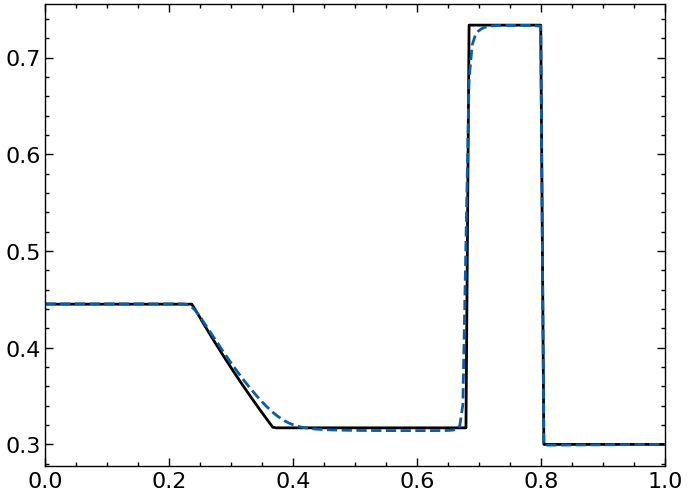

In [16]:
fig, ax = plt.subplots()
#ax.scatter(x[:],u_pred[:,0])
#ax.scatter(x[:],u_pred[:,1])
#ax.scatter(x[:],u_pred[:,2])
plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
#plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
#plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
plt.plot(x[:],u_pred[:,0],'--')
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

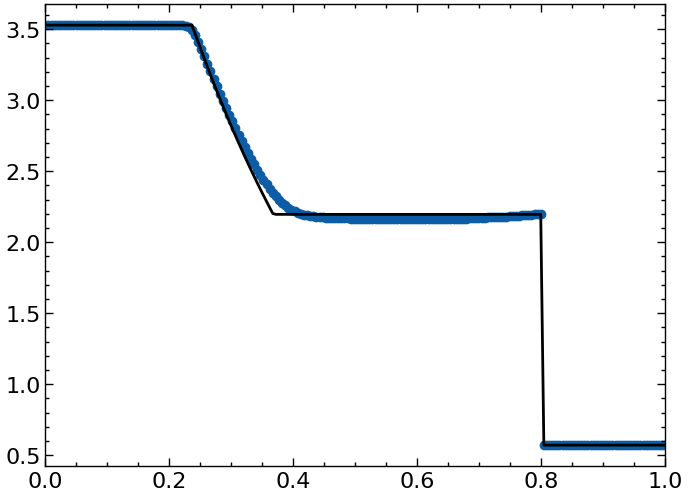

In [17]:
fig, ax = plt.subplots()
#ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
#ax.scatter(x[:],u_pred[:,2])
#plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
#plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

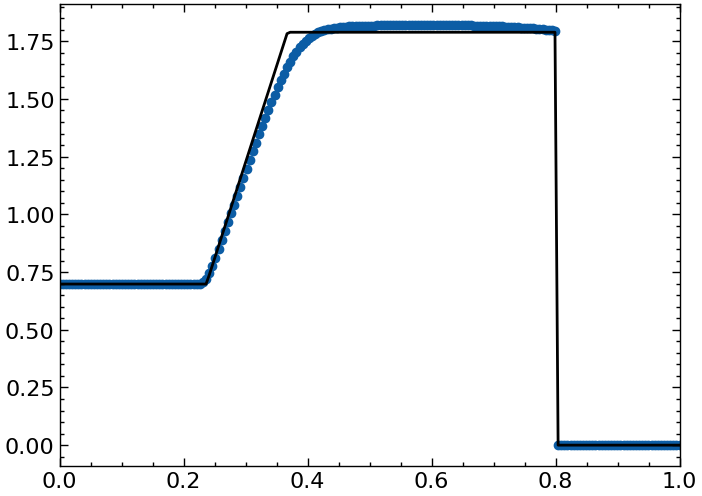

In [18]:
fig, ax = plt.subplots()
#ax.scatter(x[:],u_pred[:,0])
#ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
#plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
#plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()